# Document Similarity Graph Generation

## TODO
 * Detect edges between nodes with clashing judgements.
     * Design way of learning optimal value of similarity threshold/weights for NN/MEV methods.

In [1]:
%load_ext autoreload

In [2]:
# Debugging tip: if an import fails and you're using Anaconda, try to print
# out 'sys.executable'. It may turn out that it's pointing to the wrong
# conda env. See: https://github.com/jupyter/notebook/issues/397
from graphviz import Digraph, Graph

import numpy as np

import datetime
import io
import random
import os

In [3]:
random.seed(0xC0FFEE)

In [4]:
# This makes Jupyter pretend to be Pythonic and play well with modules.

import sys
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

In [8]:
%autoreload 2

from crowd.data import *
from crowd.config import *
from crowd.file_util import *
from crowd.graph import *
from crowd.topic import *

In [9]:
if 'notebooks' in os.getcwd():
    print(os.getcwd())
    os.chdir('..')
    print(os.getcwd())

/Users/andrei/workspace/crowd/notebooks
/Users/andrei/workspace/crowd


## Load the topic information for improved manual inspection

In [10]:
id_topic_info = load_topic_metadata()

## Load the relevance judgements to improve the visualization

In [11]:
# Turk judgements
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)

# Ground truth
# Note: it seems to be normal that there are duplicates in this dataset.
test_data = read_expert_labels(TEST_LABEL_FILE_SHARED, header=True, sep=',') + \
    read_expert_labels(TEST_LABEL_FILE_TEAMS, header=True, sep=',')
print(len(test_data))

9380


### Sample exploration of a single fixed topic

In [12]:
topics = { l.topic_id for l in judgements }

# Some topic ID we want to visualize.
target_topic_id = '20704'
assert target_topic_id in topics
print("Topic we are exploring: [%s]" % id_topic_info[target_topic_id])

topic_judgements = [j for j in judgements if j.topic_id == target_topic_id]
doc_ids_in_topic = {j.doc_id for j in topic_judgements}
print("%d turk judgements in topic [%s] of %d documents." % (len(topic_judgements), target_topic_id, len(doc_ids_in_topic)))
print("AVG: %.2f judgements per documents" % (len(topic_judgements) / len(doc_ids_in_topic)))

Topic we are exploring: [20704:detroit riot]
465 turk judgements in topic [20704] of 90 documents.
AVG: 5.17 judgements per documents


## Build and render the document graph

In [13]:
SHORT_NAME_OFFSET = 7
FILE_URI_PREFIX = 'file://'
    
def add_node(dot, node, topic_folder, relevant_documents, non_relevant_documents, vote_data, discard_empty):
    """Used by 'visualize_grap' to render a single graph node using Graphviz.
    
    Arguments:
        dot: The Graphviz 'Graph' object.
        node: The 'DocumentNode' we wish to add to the graph visualization.
        topic_folder: The folder where this topic's documents are located.
        
    Return:
        A bool indicating whether this node was kept in the graph, and not discarded
        because it e.g. didn't have any relevance information.
    """
    name = node.document_id
    short_name = name[name.rfind('-') - SHORT_NAME_OFFSET : name.rfind('.')]
    full_path = FILE_URI_PREFIX + os.path.join(topic_folder, name + ".txt")
    color = "white"

    # TODO(andrei): Consider moving this logic in the graph construction phase.
    # The ground truth information of a node will never change.
    ground_truth_relevant = None
    if name in relevant_documents:
        color = "green"
        ground_truth_relevant = True
    if name in non_relevant_documents:
        color = "red"
        ground_truth_relevant = False

    relevant_votes = 0
    irrelevant_votes = 0
    if name in vote_data:
        votes = vote_data[name]
        for vote in votes:
            if vote.is_relevant > 0:
                relevant_votes += 1
            else:
                irrelevant_votes += 1

    votes_relevance = None
    if relevant_votes > irrelevant_votes:
        votes_relevance = True
    elif relevant_votes < irrelevant_votes:
        votes_relevance = False

    if discard_empty:
        if ground_truth_relevant == None and relevant_votes == 0 and irrelevant_votes == 0:
            return False

    top_color = color
    bot_color = "lightgray"
    if votes_relevance is True:
        bot_color = "green"
    elif votes_relevance is False:
        bot_color = "red"

    border_color = "black"
    if ground_truth_relevant is not None and votes_relevance is not None:
        if ground_truth_relevant != votes_relevance:
            border_color = "yellow"

    # Yes, the extra angular brackets are necessary for graphviz.
    node_label = '''<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4" COLOR="%s">
        <TR><TD BGCOLOR="%s">%s</TD></TR>
        <TR><TD BGCOLOR="%s">(+%d -%d)</TD></TR>
    </TABLE>>''' % (border_color, top_color, short_name, bot_color, relevant_votes, irrelevant_votes)
    dot.node(name, label=node_label, fontsize='7', shape='none', height='0', width='0',
             tooltip=name, URL=full_path, style='filled', margin='0')
    
    return True

def visualize_graph(graph, base_folder, ground_truth_data, vote_data, **kw):
    """Renders the specified document graph using graphviz."""
    
    # Whether to hide document nodes which have a ground truth or any votes.
    discard_empty = kw.get('discard_empty', False)

    dot = Graph(comment='Similarity graph', engine='neato')
    dot.body.append('size="18,18"')
    dot.body.append('splines=true;')
    dot.body.append('overlap=scalexy;')
    dot.body.append('nodesep=25.0;')
    dot.body.append('label="Topic: %s (%s)"' % (graph.topic.description, graph.topic.query))
    
    relevant_documents, non_relevant_documents = get_relevant(graph.topic_id, ground_truth_data)
    print("We have %d relevant and %d non-relevant ground truths for this topic." % (len(relevant_documents), len(non_relevant_documents)))

    topic_folder = os.path.join(base_folder, str(graph.topic_id))
    hidden_node_ids = set()
    
    # Create the nodes
    for node in graph.nodes:
        kept = add_node(dot, node, topic_folder, relevant_documents, non_relevant_documents, vote_data, discard_empty)
        if not kept:
            hidden_node_ids.add(node.document_id)

    # Add the edges
    for node in graph.nodes:
        if node.document_id in hidden_node_ids: continue
        for neighbor in node.neighbors:
            if neighbor.to_document_id in hidden_node_ids: continue
            # Ensure each edge is drawn exactly once.
            if neighbor.to_document_id > neighbor.from_document_id:
                label = "%.3f" % neighbor.similarity
                dot.edge(
                    neighbor.from_document_id, neighbor.to_document_id,
                    label=label,
                    fontsize='6')
                
    print("Shown nodes: {}".format(len(graph.nodes) - len(hidden_node_ids)))
    print("Hidden nodes: {}".format(len(hidden_node_ids)))
                
    return dot

In [14]:
from collections import OrderedDict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

We have 5 relevant and 5 non-relevant ground truths for this topic.
Shown nodes: 141
Hidden nodes: 0


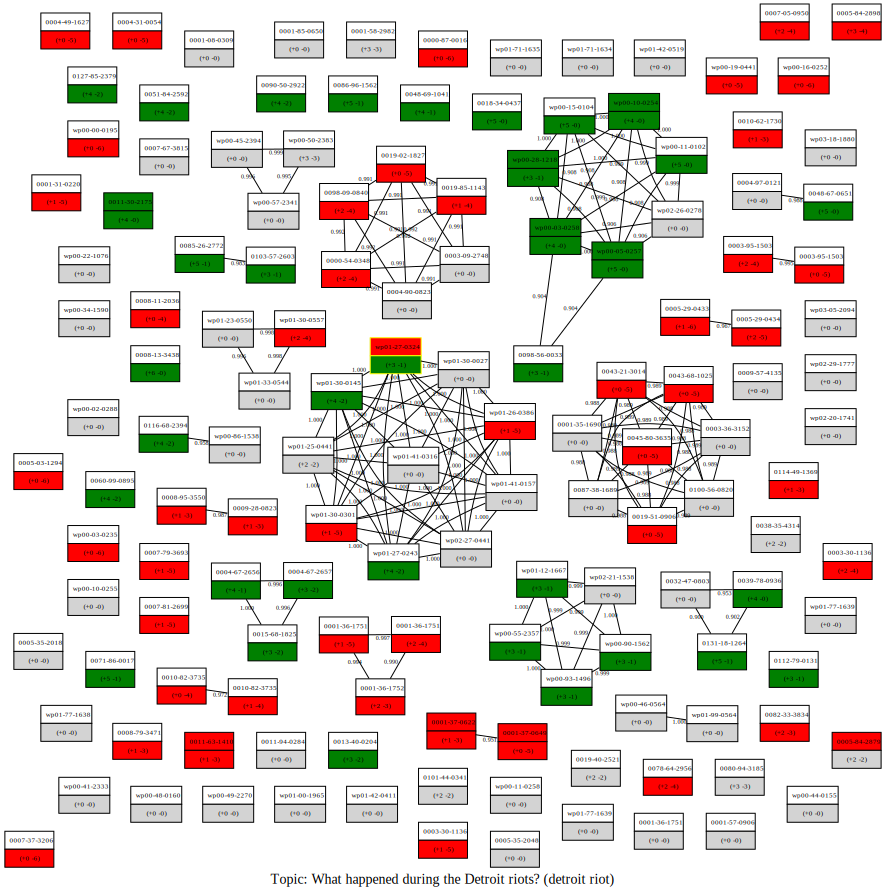

In [15]:
fmt_topic = lambda t: "[%s] %s (%d)" % (t.topic_id, t.query, t.document_count)
optlist = ((fmt_topic(t), t.topic_id) for t in id_topic_info.values())
options=OrderedDict(sorted(optlist))

@interact(
    topic_id=widgets.Dropdown(options=options),
    sim_threshold=widgets.FloatSlider(
        min=0.50,
        max=1.0,
        step=0.025,
        continuous_update=False,
        value=0.90),
    should_discard_empty_nodes=widgets.Checkbox(
        description="Hide nodes with no ground truth or any votes",
        value=True)
)
def build_and_display(topic_id, sim_threshold, should_discard_empty_nodes):
    topic = id_topic_info[topic_id]
    graph = build_document_graph(topic, FULLTEXT_FOLDER, sim_threshold=sim_threshold)
    graph_dot = visualize_graph(
        graph,
        FULLTEXT_FOLDER,
        test_data,
        get_topic_judgements_by_doc_id(topic_id, judgements),
        discard_empty=should_discard_empty_nodes)
    return graph_dot

## Using NetworkX

In [12]:
res = build_nx_document_graph(id_topic_info['20958'], FULLTEXT_FOLDER)

print("{} document nodes.".format(res.nx_graph.number_of_nodes()))
print("{} similarity edges.".format(res.nx_graph.number_of_edges()))

TypeError: build_nx_document_graph() missing 2 required positional arguments: 'vote_data' and 'fulltext_folder'

In [ ]:
import networkx as nx

# TODO(andrei): Use networkx in the main graph structure anyway.
def to_networkx(graph, bast_folder, ground_truth_data, vote_data, **kw):
    pass

# TODO(andrei): Remove this.
def visualize_graph(graph, base_folder, ground_truth_data, vote_data, **kw):
    """Renders the specified document graph using graphviz."""
    
    # Whether to hide document nodes which have a ground truth or any votes.
    discard_empty = kw.get('discard_empty', False)

    dot = Graph(comment='Similarity graph', engine='neato')
    dot.body.append('size="18,18"')
    dot.body.append('splines=true;')
    dot.body.append('overlap=scalexy;')
    dot.body.append('nodesep=25.0;')
    dot.body.append('label="Topic: %s (%s)"' % (graph.topic.description, graph.topic.query))
    
    relevant_documents, non_relevant_documents = get_relevant(graph.topic_id, ground_truth_data)
    print("We have %d relevant and %d non-relevant ground truths for this topic." % (len(relevant_documents), len(non_relevant_documents)))

    topic_folder = os.path.join(base_folder, str(graph.topic_id))
    hidden_node_ids = set()
    
    # Create the nodes
    for node in graph.nodes:
        kept = add_node(dot, node, topic_folder, relevant_documents, non_relevant_documents, vote_data, discard_empty)
        if not kept:
            hidden_node_ids.add(node.document_id)

    # Add the edges
    for node in graph.nodes:
        if node.document_id in hidden_node_ids: continue
        for neighbor in node.neighbors:
            if neighbor.to_document_id in hidden_node_ids: continue
            # Ensure each edge is drawn exactly once.
            if neighbor.to_document_id > neighbor.from_document_id:
                label = "%.3f" % neighbor.similarity
                dot.edge(
                    neighbor.from_document_id, neighbor.to_document_id,
                    label=label,
                    fontsize='6')
                
    return dot